In [1]:
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from keras.layers import *
import tensorflow as tf
import numpy as np

c:\Users\phong\.conda\envs\tf\lib\site-packages\h5py\__init__.py:36: UserWarning: h5py is running against HDF5 1.12.2 when it was built against 1.12.1, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


## Layers

In [2]:
def conv_unit(feat_dim, kernel_size, x_in, padding="CONSTANT"):
    """
    Conv unit: x_in --> Conv k x k + relu --> Conv 1 x 1 + relu --> output
    Parameter: 
                - x_in (tensor): input tensor
                - feat_dim (int): number of channels
                - kernel_size (k) (int): size of convolution kernel
                - padding (str): padding method to use
    Return:
                - (tensor): output of the conv unit
    """
    x = Conv2D(feat_dim, kernel_size, activation=LeakyReLU(0.2), padding="same")(x_in)
    x = Conv2D(feat_dim, 1, activation=LeakyReLU(0.2), padding="same")(x)
    return x

def conv_block_down(x, feat_dim, reps, kernel_size, mode='normal', padding="CONSTANT"):
    if mode == 'down':
        x = MaxPooling2D(2,2)(x)
    for _ in range(reps):
        x = conv_unit(feat_dim, kernel_size, x, padding)
    return x

def conv_block_up_w_concat(x, x1, feat_dim, reps, kernel_size, mode='normal', padding="CONSTANT"):
    if mode == 'up':
        x = UpSampling2D((2,2),interpolation='bilinear')(x)
    x = Concatenate()([x,x1])
    for _ in range(reps):
        x = conv_unit(feat_dim, kernel_size, x, padding)
    return x

def conv_block_up_wo_concat(x, feat_dim, reps, kernel_size, mode='normal', padding="CONSTANT"):
    if mode == 'up':
        x = UpSampling2D((2,2),interpolation='bilinear')(x)
    for _ in range(reps):
        x = conv_unit(feat_dim, kernel_size, x, padding)
    return x


In [3]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs

        epsilon = tf.random.normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


## VAE

In [4]:
# Encoder
def vgg_encoder(latent_dims = 4, input_shape = (128,256,1), n_base_features = 64):
    inputs = keras.Input(shape = input_shape)
    conv1 = conv_block_down(inputs,
                            feat_dim = n_base_features,
                            reps = 1,
                            kernel_size = 3,
                            mode = 'down')
    conv2 = conv_block_down(conv1,
                            feat_dim = n_base_features*2,
                            reps = 1,
                            kernel_size = 3,
                            mode = 'down')
    conv3 = conv_block_down(conv2,
                            feat_dim = n_base_features*2,
                            reps = 2,
                            kernel_size = 3,
                            mode = 'down')
    conv4 = conv_block_down(conv3,
                            feat_dim = n_base_features*4,
                            reps = 2,
                            kernel_size = 3,
                            mode = 'down')
    conv5 = conv_block_down(conv4,
                            feat_dim = n_base_features*4,
                            reps = 2,
                            kernel_size = 3,
                            mode = 'down')   
    
    z_mean = layers.Conv2D(latent_dims,3, padding="same",name="z_mean")(conv5)
    z_log_var = layers.Conv2D(latent_dims,3, padding="same",name="z_log_var")(conv5)
    z = Sampling()([z_mean,z_log_var])
    encoder = keras.Model(inputs, [z_mean,z_log_var,z])
    return encoder
vgg_encoder().summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 64, 128, 1)   0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 64, 128, 64)  640         ['max_pooling2d[0][0]']          
                                                                                                  
 conv2d_1 (Conv2D)              (None, 64, 128, 64)  4160        ['conv2d[0][0]']             

In [5]:
# Decoder
def vgg_decoder(input_shape = (4,8,4), n_base_features = 64):
    inputs = keras.Input(shape = input_shape)
    conv_in = layers.Conv2D(n_base_features*4, 3, activation = LeakyReLU(0.2), padding="same")(inputs)

    conv1 = conv_block_up_wo_concat(conv_in,
                            feat_dim = n_base_features*4,
                            reps = 2,
                            kernel_size = 3,
                            mode = 'up')
    conv2 = conv_block_up_wo_concat(conv1,
                            feat_dim = n_base_features*4,
                            reps = 2,
                            kernel_size = 3,
                            mode = 'up')
    conv3 = conv_block_up_wo_concat(conv2,
                            feat_dim = n_base_features*2,
                            reps = 1,
                            kernel_size = 3,
                            mode = 'up')
    conv4 = conv_block_up_wo_concat(conv3,
                            feat_dim = n_base_features*2,
                            reps = 1,
                            kernel_size = 3,
                            mode = 'up')
    conv5 = conv_block_up_wo_concat(conv4,
                            feat_dim = n_base_features,
                            reps = 1,
                            kernel_size = 3,
                            mode = 'up')
    conv_out = layers.Conv2D(1, 3, padding="same")(conv5)
    decoder = keras.Model(inputs, conv_out)
    return decoder
vgg_decoder().summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 4, 8, 4)]         0         
                                                                 
 conv2d_16 (Conv2D)          (None, 4, 8, 256)         9472      
                                                                 
 up_sampling2d (UpSampling2D  (None, 8, 16, 256)       0         
 )                                                               
                                                                 
 conv2d_17 (Conv2D)          (None, 8, 16, 256)        590080    
                                                                 
 conv2d_18 (Conv2D)          (None, 8, 16, 256)        65792     
                                                                 
 conv2d_19 (Conv2D)          (None, 8, 16, 256)        590080    
                                                           

## Sensor - Latent var mapping

In [22]:
# Neural network
no_of_sensor = 32

def create_mapping_operator(no_of_sensor = 8, latent_dim = (4,8,4)):
    inputs = keras.Input(shape = (no_of_sensor))
    fc_1 = Dense(128, activation=LeakyReLU(0.2))(inputs)
    fc_2 = Dense(256, activation=LeakyReLU(0.2))(fc_1)
    fc_3 = Dense(512, activation=LeakyReLU(0.2))(fc_2)
    fc_3 = Dense(256, activation=LeakyReLU(0.2))(fc_2)
    fc_4 = Dense(128)(fc_3)
    latent_var = Reshape(target_shape=latent_dim)(fc_4)
    z_mean = layers.Conv2D(latent_dim[2],3, padding="same",name="z_mean")(latent_var)
    z_log_var = layers.Conv2D(latent_dim[2],3, padding="same",name="z_log_var")(latent_var)
    z = Sampling()([z_mean,z_log_var])
    mapping = keras.Model(inputs, [z_mean,z_log_var,z])
    return mapping
# create_mapping_operator().summary()

In [7]:
class Binary2RGB(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        return tf.image.grayscale_to_rgb(inputs)

In [8]:
def vgg():
    inputs = keras.Input(shape = (128, 256,1))
    rgb = Binary2RGB()(inputs)
    vgg = tf.keras.applications.inception_v3.InceptionV3(include_top=False,
                                                       weights='imagenet',
                                                       input_shape = (128,256,3),   
                                                       pooling=max)
    feature = vgg(rgb)
    vgg_model = keras.Model(inputs, feature)
    vgg_model.trainable = False
    return vgg_model

## Trainer 

In [9]:
# Trainer class
class FLRNet(keras.Model):
    def __init__(self,  n_sensor = 8, **kwargs):
        super().__init__(**kwargs)
        self.encoder = vgg_encoder()
        self.decoder = vgg_decoder()
        self.sens_mapping = create_mapping_operator(no_of_sensor=n_sensor)
        # self.vgg19 = vgg()

        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss_ae"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss_ae")
        self.sens_reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss_sens"
        )
        self.sens_kl_loss_tracker = keras.metrics.Mean(name="kl_loss_sens")
        
    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
            self.sens_reconstruction_loss_tracker,
            self.sens_kl_loss_tracker,
        ]
    def kld(self, mean_1, mean_2, z_log_var_1, z_log_var_2):
        var_1 = tf.exp(z_log_var_1)
        var_2 = tf.exp(z_log_var_2)
        kl_loss = ( 
            tf.math.log((var_2 / var_1) ** 0.5) 
              + (var_1 + (mean_1 - mean_2) ** 2) / (2 * var_2) 
              - 0.5
           )
        return kl_loss
    
    def perceptual_loss(self, y_pred, gt):
        # Pred perceptaul
        pred_feature = self.vgg19(y_pred)
        # GT perceptual
        gt_feature = self.vgg19(gt)
        return tf.keras.losses.MeanSquaredError(reduction = 'sum')(pred_feature,gt_feature)
    
    def train_step(self, data):
        sens_inp = tf.cast(data[0], dtype = tf.float32)
        img_inp = tf.cast(data[1],dtype = tf.float32)
        with tf.GradientTape() as tape:
            # Autoencoder
            z_mean_ae, z_log_var_ae, z_ae = self.encoder(img_inp)
            reconstruction_ae = self.decoder(z_ae)
            reconstruction_loss_ae = tf.keras.losses.MeanAbsoluteError(reduction = 'sum')(reconstruction_ae,img_inp)
            
            kl_loss_ae = -0.5 * (1 + z_log_var_ae - tf.square(z_mean_ae) - tf.exp(z_log_var_ae))
            kl_loss_ae = (tf.reduce_sum(kl_loss_ae, axis=(1,2,3)))


            # # Metric loss
            # u_dot = img_inp[:,:,:,1] - img_inp[:,:,:,0] #Compute u_dot
            # z_dot_enc = z_mean_ae_1 - z_mean_ae_2
            # with tf.autodiff.ForwardAccumulator(
            #     primals= self.encoder.trainable_weights,
            #     tangents= u_dot) as acc:
            #     z_mean_metric, _, _ = self.encoder(img_inp)
            # z_dot_compute = acc.jvp(z_mean_metric)
            # metric_loss = tf.keras.losses.MeanAbsoluteError(reduction = 'sum')(z_dot_compute, z_dot_enc)

            # perceptual_loss_ae = self.perceptual_loss(reconstruction_ae,img_inp)

            # Sens recon
            z_mean_sens, z_log_var_sens, z_sens = self.sens_mapping(sens_inp)
            reconstruction_sens = self.decoder(z_sens)
            reconstruction_loss_sens = tf.keras.losses.MeanAbsoluteError(reduction = 'sum')(reconstruction_sens,img_inp)
            
            kl_loss_sens = self.kld(z_mean_sens,z_mean_ae,z_log_var_sens, z_log_var_ae)
            kl_loss_sens = (tf.reduce_sum(kl_loss_sens, axis=(1,2,3)))

            # perceptual_loss_sens = self.perceptual_loss(reconstruction_sens,img_inp)

            total_loss = reconstruction_loss_ae + kl_loss_ae + 2*reconstruction_loss_sens + 2*kl_loss_sens 
            # + perceptual_loss_ae + perceptual_loss_sens
            
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss_ae)
        self.kl_loss_tracker.update_state(kl_loss_ae)
        self.sens_reconstruction_loss_tracker.update_state(reconstruction_loss_sens)
        self.sens_kl_loss_tracker.update_state(kl_loss_sens)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss_ae": self.reconstruction_loss_tracker.result(),
            "kl_loss_ae": self.kl_loss_tracker.result(),
            "reconstruction_loss_sens": self.sens_reconstruction_loss_tracker.result(),
            "kl_loss_sens": self.sens_kl_loss_tracker.result(),
        }

## Data preparation

In [23]:
# Prepare field data
Re_list_train = [300, 400, 450, 500, 600, 650, 700, 800, 850, 900, 1000]
Re_list_test = [350, 550, 750, 950]

sensor_data_whole = []
full_field_data_whole = []
for Re in Re_list_train:
    filename = "E:/Research/Data/flow_field_recon/random_sensor_data/sensor_data_" + str(no_of_sensor) + "_" + str(Re) + ".npy"
    sensor_data = np.load(filename)
    sensor_data_whole.append(sensor_data)
    filename_field = "E:/Research/Data/flow_field_recon/full_field_data/full_field_data_" + str(Re) + ".npy"
    full_field_data_whole.append(np.load(filename_field))

sensor_data_whole_array = np.swapaxes(np.concatenate(sensor_data_whole,axis = -1), 0,1)
full_field_data_whole_array = np.swapaxes(
    np.expand_dims(
        np.concatenate(full_field_data_whole, axis = -1), axis = 0),
        0, -1)

print(sensor_data_whole_array.shape)
print(full_field_data_whole_array.shape)



(429, 32)
(429, 128, 256, 1)


In [24]:
# Normalization
min_val = np.amin(full_field_data_whole_array)
max_val = np.amax(full_field_data_whole_array)
full_field_data_whole_array_norm = (full_field_data_whole_array - min_val)/(max_val - min_val)
sensor_data_whole_array_norm = (sensor_data_whole_array - min_val)/(max_val - min_val)

# Test
print("Check field data: ", np.amin(full_field_data_whole_array_norm), np.amax(full_field_data_whole_array_norm))
print("Check sens data: ", np.amin(sensor_data_whole_array_norm), np.amax(sensor_data_whole_array_norm))

Check field data:  0.0 1.0
Check sens data:  0.009823586802403443 0.8915568029359625


In [12]:
# Create tf.dataset
dataset = tf.data.Dataset.from_tensor_slices((sensor_data_whole_array_norm,full_field_data_whole_array_norm))
dataset = dataset.shuffle(buffer_size = 2192) 
dataset = dataset.batch(8)
print(dataset)

<BatchDataset element_spec=(TensorSpec(shape=(None, 8), dtype=tf.float64, name=None), TensorSpec(shape=(None, 128, 256, 1), dtype=tf.float64, name=None))>


In [ ]:
# Prepare sensor data


## Training

In [53]:
# tf.keras.backend.clear_session()
# flow_recon_net = FLRNet(n_sensor = no_of_sensor)
flow_recon_net.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.000075, beta_1 = 0.5, beta_2 = 0.999))
flow_recon_net.fit(dataset, epochs = 500, shuffle = True)

Epoch 1/500
54/54 [==============================] - 30s 245ms/step - loss: 6083.5556 - reconstruction_loss_ae: 1495.2089 - kl_loss_ae: 260.0718 - reconstruction_loss_sens: 1846.5647 - kl_loss_sens: 200.1523
Epoch 2/500
54/54 [==============================] - 13s 240ms/step - loss: 5917.7925 - reconstruction_loss_ae: 1431.2991 - kl_loss_ae: 258.6724 - reconstruction_loss_sens: 1916.0952 - kl_loss_sens: 200.6072
Epoch 3/500
54/54 [==============================] - 13s 241ms/step - loss: 5757.3534 - reconstruction_loss_ae: 1381.1755 - kl_loss_ae: 260.6483 - reconstruction_loss_sens: 1852.3154 - kl_loss_sens: 202.1647
Epoch 4/500
54/54 [==============================] - 13s 234ms/step - loss: 5443.4324 - reconstruction_loss_ae: 1417.7472 - kl_loss_ae: 261.6126 - reconstruction_loss_sens: 1748.2632 - kl_loss_sens: 201.2539
Epoch 5/500
54/54 [==============================] - 13s 232ms/step - loss: 5579.4010 - reconstruction_loss_ae: 1403.4656 - kl_loss_ae: 259.8431 - reconstruction_loss_s

KeyboardInterrupt: 

In [42]:
flow_recon_net.encoder.save_weights('encoder_8_cir_per.h5')
flow_recon_net.decoder.save_weights('decoder_8_cir_per.h5')
flow_recon_net.sens_mapping.save_weights('mapping_8_cir_per.h5')

## Validation

In [25]:
# Prepare field data

Re_list_train = [300, 400, 450, 500, 600, 650, 700, 800, 850, 900, 1000]
Re_list_test = [350, 550, 750, 950]

sensor_data_whole = []
full_field_data_whole = []
for Re in Re_list_test:
    filename = "E:/Research/Data/flow_field_recon/random_sensor_data/sensor_data_" + str(no_of_sensor) + "_" + str(Re) + ".npy"
    sensor_data = np.load(filename)
    sensor_data_whole.append(sensor_data)
    filename_field = "E:/Research/Data/flow_field_recon/full_field_data/full_field_data_" + str(Re) + ".npy"
    full_field_data_whole.append(np.load(filename_field))

sensor_data_whole_test = np.swapaxes(np.concatenate(sensor_data_whole,axis = -1), 0,1)
full_field_data_whole_test = np.swapaxes(
    np.expand_dims(
        np.concatenate(full_field_data_whole, axis = -1), axis = 0),
        0, -1)

print(sensor_data_whole_test.shape)
print(full_field_data_whole_test.shape)

full_field_data_whole_test_norm = (full_field_data_whole_test - min_val)/(max_val - min_val)
sensor_data_whole_test_norm = (sensor_data_whole_test - min_val)/(max_val - min_val)

# Test
print("Check field data: ", np.amin(full_field_data_whole_test_norm), np.amax(full_field_data_whole_test_norm))
print("Check sens data: ", np.amin(sensor_data_whole_test_norm), np.amax(sensor_data_whole_test_norm))

(156, 32)
(156, 128, 256, 1)
Check field data:  0.0 0.9929987273789493
Check sens data:  0.01172428205383121 0.9341508515849368


In [26]:
tf.keras.backend.clear_session()
flow_recon_net = FLRNet(n_sensor = no_of_sensor)
flow_recon_net.encoder.load_weights('encoder_32_ran.h5')
flow_recon_net.decoder.load_weights('decoder_32_ran.h5')
flow_recon_net.sens_mapping.load_weights('mapping_32_ran.h5')

In [27]:
# Save model weight
# Reconstruction
case_idx = 3
_, _, z_sens = flow_recon_net.sens_mapping(sensor_data_whole_test_norm[39*case_idx:(39*(case_idx +1)),:])
reconstruction_sens = flow_recon_net.decoder(z_sens)

reconstruction_sens = reconstruction_sens.numpy()

In [46]:
reconstruction_sens.shape

(39, 128, 256, 1)

In [16]:
import matplotlib.pyplot as plt

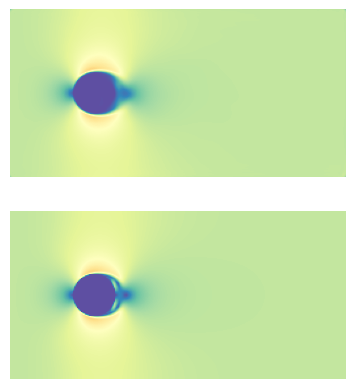

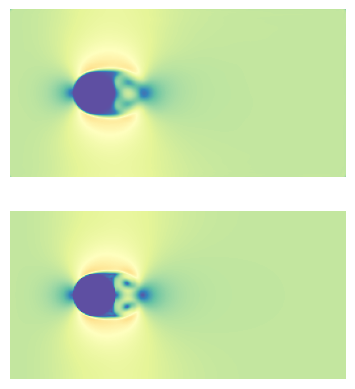

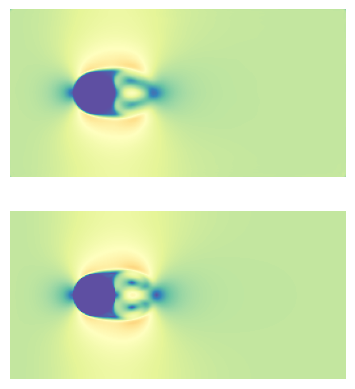

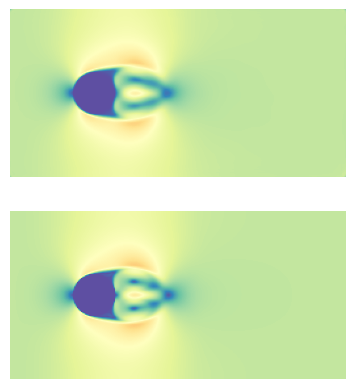

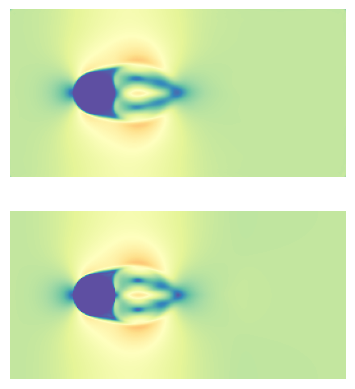

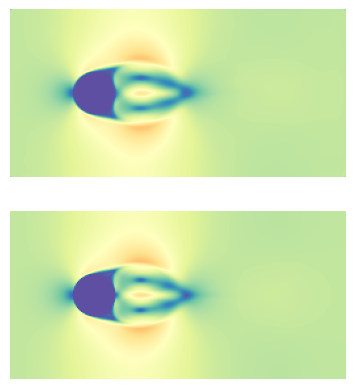

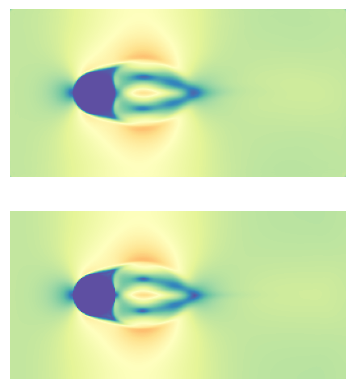

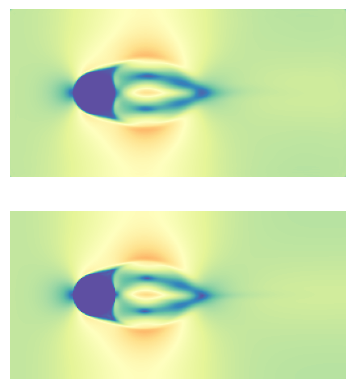

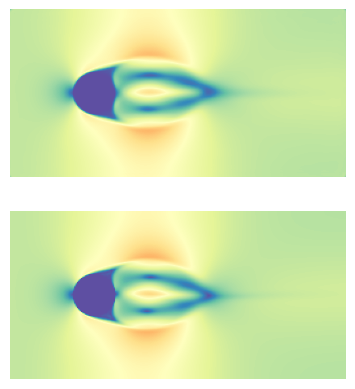

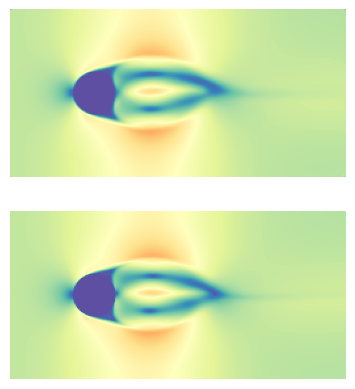

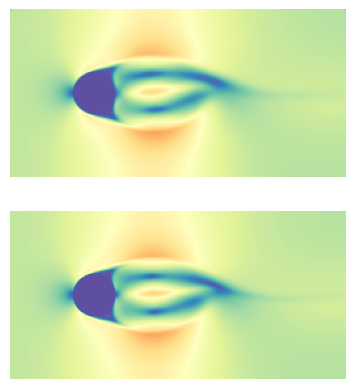

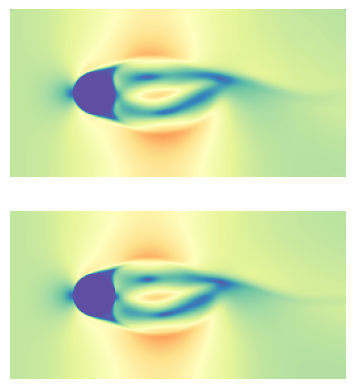

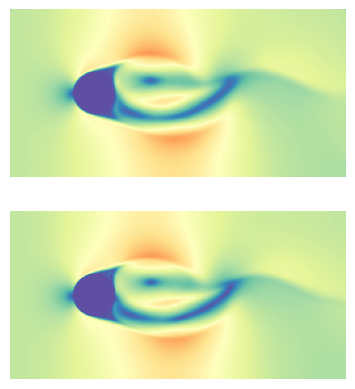

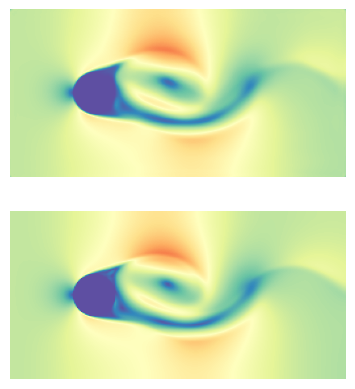

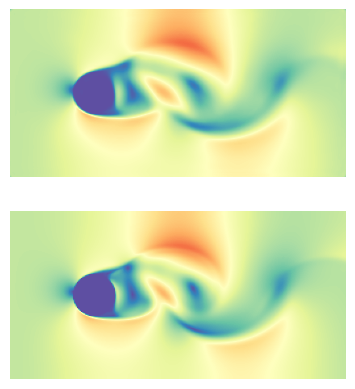

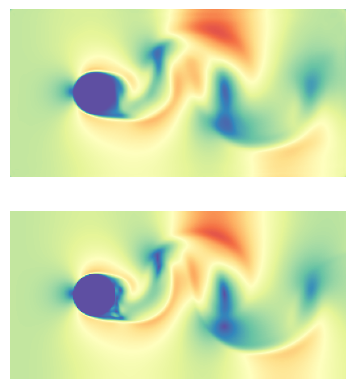

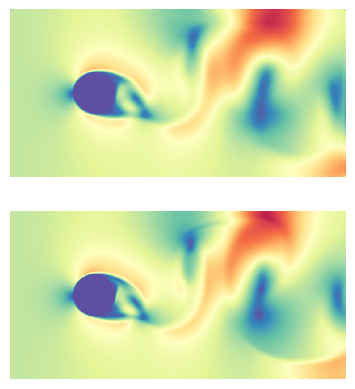

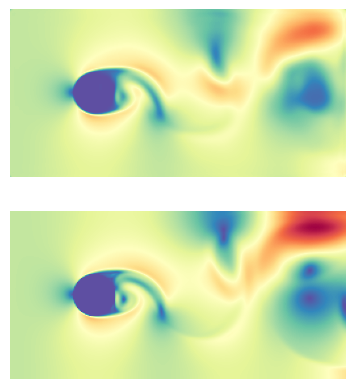

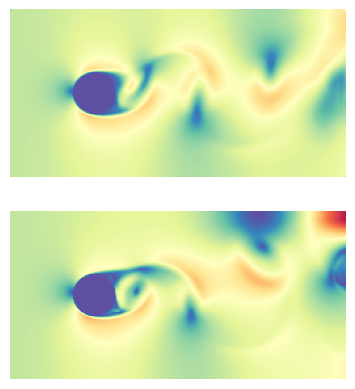

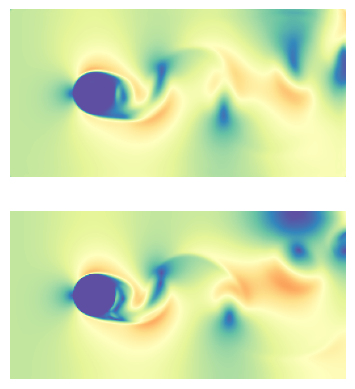

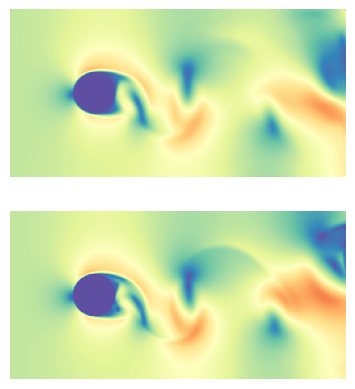

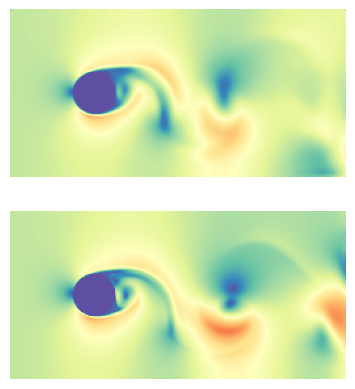

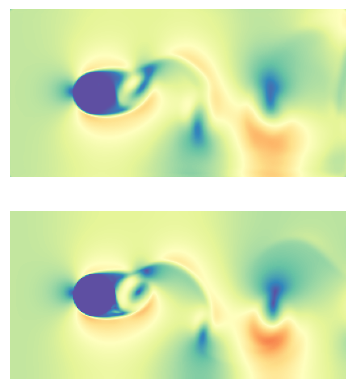

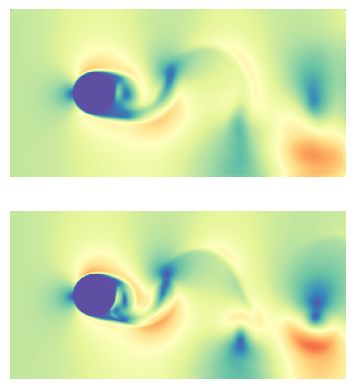

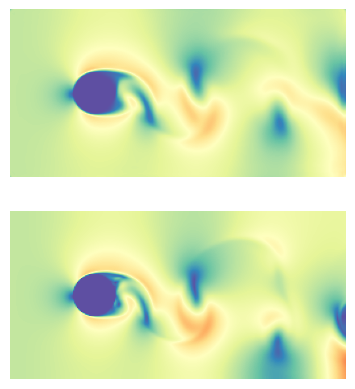

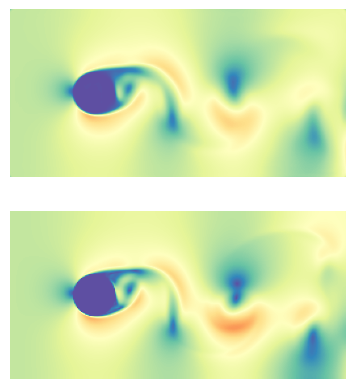

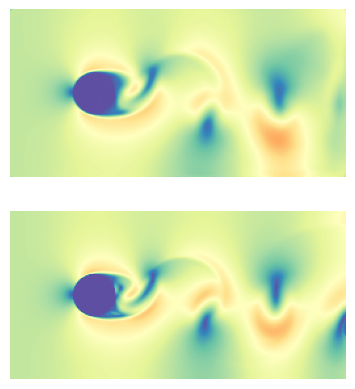

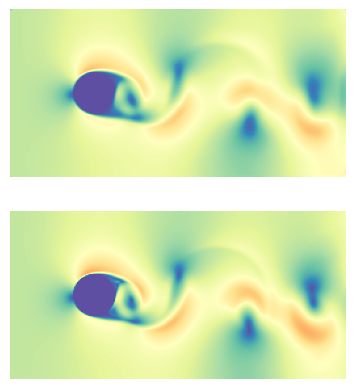

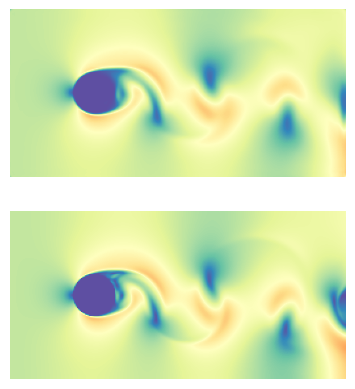

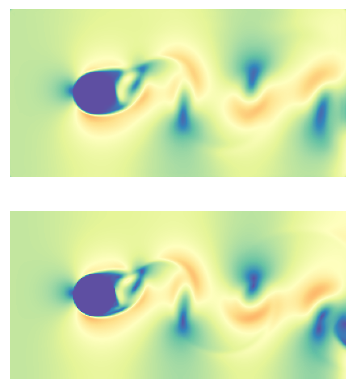

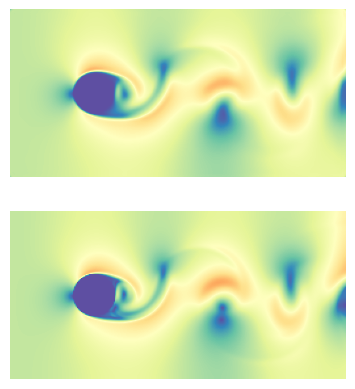

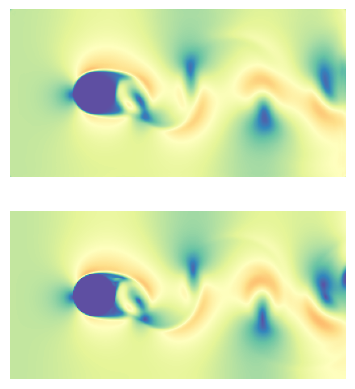

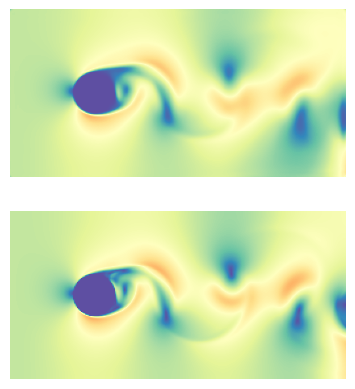

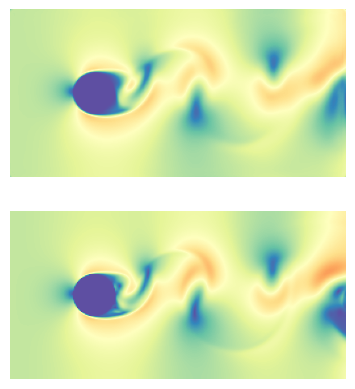

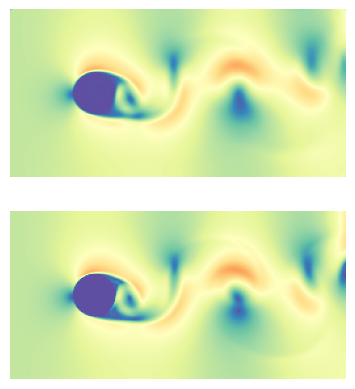

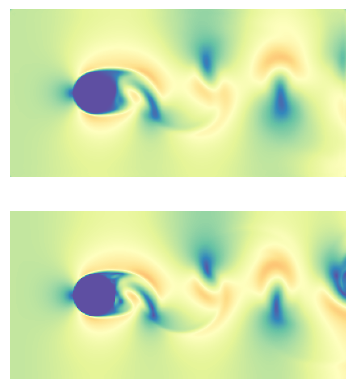

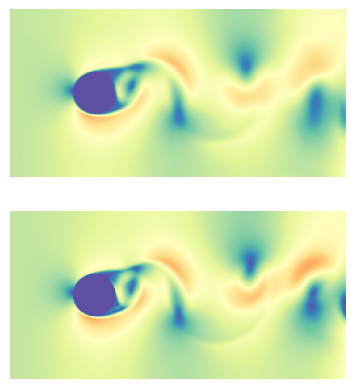

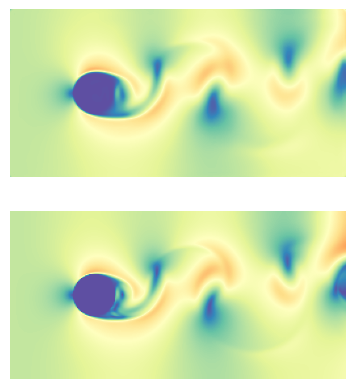

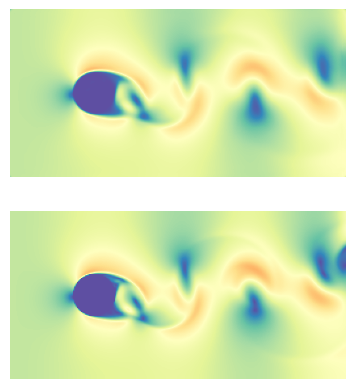

IndexError: index 39 is out of bounds for axis 0 with size 39

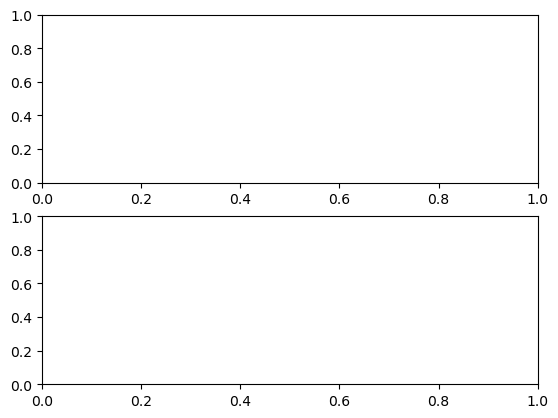

In [28]:
for i in range(40):
    _, ax = plt.subplots(2,1)
    ax[0].imshow(reconstruction_sens[i,:,:,0], vmin= 0 ,vmax = 1, cmap = 'Spectral_r')
    ax[0].axis("off")
    ax[1].imshow(full_field_data_whole_test_norm[i+39*case_idx,:,:,0], vmin= 0 ,vmax = 1,cmap = 'Spectral_r')
    ax[1].axis("off")
    plt.show()